# CIS 5450 Homework 5: Deep Learning with Pytorch

### Due Wednesday, November 29, 2023 10:00 PM EST

Welcome to CIS 5450 Homework 5!

In this homework, we will learn more about the 'new electricity' - Deep Learning (I didn't coin this, Andrew Ng did) ! There are many cool frameworks for building deep learning models - PyTorch, Tensorflow, Theano, MxNet. Since you will be working with Big Data in this course, you need a framework that scales well. Almost all of these have a multi-gpu support built in. In this assignment, we will be building neural networks in PyTorch to solve an interesting problem.

Deep learning or neural network architectures have been used to solve a multitude of problems in various different fields like vision, natural language processing. So let's take a 'deep' dive into it.






## Why deep learning?


*   It's coooool
*   Everyone is talking about is these days, people like Siraj Raval can teach it in 5 mins (Check out his [YouTube channel](https://www.youtube.com/channel/UCWN3xxRkmTPmbKwht9FuE5A) for some comedy)
*    Deep learning unlocks the treasure trove of unstructured big data for those with the imagination to use it
*   Deep learning models have great representational power and are 'universal approximators'


### Deep Learning Applications:


Deep learning has significantly improved voice command systems (such as Siri and Alexa), as well as healthcare and image identification.

Deep learning has applications across numerous industries, which is why experts think that this technology is the future of almost everything. There are truly deep learning technologies such as Google’s very human-like talking AI, a new theory that cracks the 'black box' of deep learning, and various budding ideas like this one about why human forgetting might be the key to AI. Here are some cool applications of deep learning -

Here's a neural network detecting anomalies in Chest Xrays :




Pretty cool, right? We will be applying CNNs to solve a cool image classification problem.


# Libraries and Setup Jargon (Total: 1 point)
Run the following cells to set up the notebook.


Please make sure you enter your **8 digit Penn ID** in the  student ID field below.

In [ ]:
%%capture
!pip install penngrader-client
from penngrader.grader import *

#PLEASE ENSURE YOUR PENN-ID IS ENTERED CORRECTLY. IF NOT, THE AUTOGRADER WON'T KNOW WHO
#TO ASSIGN POINTS TO YOU IN OUR BACKEND

STUDENT_ID = 48580633       # YOUR PENN-ID GOES HERE AS AN INTEGER

In [ ]:
%%writefile config.yaml
grader_api_url: 'https://23whrwph9h.execute-api.us-east-1.amazonaws.com/default/Grader23'
grader_api_key: 'flfkE736fA6Z8GxMDJe2q8Kfk8UDqjsG3GVqOFOa'

Overwriting config.yaml


In [ ]:
grader = PennGrader('config.yaml', 'CIS5450_F23_HW5', STUDENT_ID, STUDENT_ID)

PennGrader initialized with Student ID: 48580633

Make sure this correct or we will not be able to store your grade


## Import the required Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from sklearn.model_selection import train_test_split
import torch
import torchvision
from torchvision import transforms, utils
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from collections import Counter
from PIL import Image
from skimage import io, transform
import os
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from google.colab import drive
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA

## Set up GPU capabilities (1 point)

The cell below sets up a CUDA device to use with torch, if available to you.

**Remeber to turn on the GPU for runtime in Colab**
*   Go to Runtime -> Change runtime type --> GPU


Note that you can create a PyTorch tensor `T` that resides on the GPU using the command `T = torch.Tensor(..., device=cuda)`.
You can also copy existing tensors to the GPU with the command `T = T.to(device)` (make sure to overwrite `T` with the result of this function call). If you do not have a GPU, these commands will still work.

**NOTE**: The grader cell below is to check that you are using the GPU, since it is beneficial in later sections that require parallel computation on arrays (i.e., Section 2).

In [ ]:
# DO NOT MODIFY
torch.manual_seed(42) # For grading consistency
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.__version__)
print(device)

2.1.0+cu118
cuda:0


In [ ]:
device

device(type='cuda', index=0)

In [ ]:
# Grader Cell (1 points)
grader.grade(test_case_id = 'device', answer = str(device))

Correct! You earned 1/1 points. You are a star!

Your submission has been successfully recorded in the gradebook.


# **Part 1:** Data Preprocessing and Preparation for Modeling in `PyTorch` (Total: 14 points)

In this homework we will tackle the problem of classifying images.

Specifically, we would be looking at a somewhat famous dataset from Stanford.

Dataset Citation:

Yuval Netzer, Tao Wang, Adam Coates, Alessandro Bissacco, Bo Wu, Andrew Y. Ng Reading Digits in Natural Images with Unsupervised Feature Learning NIPS Workshop on Deep Learning and Unsupervised Feature Learning 2011.

The dataset is called Street View House Numbers (or SVHN). The dataset consists of images of **house numbers**, taken from Google Street View. There are 10 classes, one for each digit (0-9).


For more information about the dataset, please look [here](http://ufldl.stanford.edu/housenumbers/)

There are 73,257 sample digits for training, 26,032 samples for testing, and 531131 extra samples because, well, why not I guess.

In a future section (**after section 1.1.1**) we will downsample and train the model with 30,000 training samples and 5,000 testing samples. This is for two reasons: first, to avoid having long training time and potentially running out of GPU, and the second reason you will see after section 1.2.2


We would be using this dataset to train 3 different models:

1.   Logistic Regression
2.   Feedforward (Fully-Connected) Neural Network (FNN)
3.   Convolutional Neural Network (CNN)

And analyze the difference between these models by looking at the test accuracy and loss.

## 1.1 Pytorch Dataset (Total: 4 points)

To keep data loading consistent across different models, PyTorch provides two data primitives: `torch.utils.data.DataLoader` and `torch.utils.data.Dataset` that allow you to use pre-loaded datasets as well as your own data.

`Dataset` stores the samples and their corresponding labels. And `DataLoader` wraps an iterable around the Dataset to enable easy access to the samples. More information and examples of the objects in action can be found **[here](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)**

While Pytorch provides `Dataset` and `Dataloader` for some popular datasets (i.e., one can instantiate the objects and the data is ready to be analyzed in PyTorch Machine Learning pipeline), sometimes we need to define our own custom `Dataset` to process our dataset. The list of available built-in datasets PyTorch gave us can be found **[here](https://pytorch.org/vision/stable/datasets.html)**


Dataset class is defined with 3 components:

1.   __init__ : setting up the parameters being used in the class (e.g., `transforms` which corresponds to the transformation being applied)
2.   __len__ : so that len(dataset) returns the size of the dataset.
3.   __getitem__ to support the indexing such that `dataset[i]` can be used to get `i`ith sample (in our case Image, label pair).

To create a custom Dataset object, you would need overide above functions.

Documentation for creating custom dataset can be found [here](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

Luckily, as MNIST is a classic image dataset, we do not need to worry about creating custom `Dataset` and `DataLoader` objects since they are all built into the PyTorch when you import that above.

Complete the missing code in the two sections below.

*   **1.1.1 Instantiate Train and Test Dataset.** $\to$ Load and transform data such that it is ready to be passed into the model. Ensure the training dataset is of size 73257 and the testing dataset is of size 26032 for this step


### 1.1.1 Instantiate Dataset (for train/test dataset) (4 points)

One optional function in Dataset class is `transform`, where we can apply a transformation to the dataset before we load them as a dataloader.

For example if we define a `Resize` function in transform, all of our dataset(images) would be resized to specified size passed in as an argument.

---
**TODO**: complete the code to apply following transformations (in order!!) by using `transforms.Compose` and save it to the variable `transform`:

1.   Resize the image to 32 by 32 $\to$ just to make sure they are really have size $32$x$32$
2.   Convert the images to Tensor
3.   Normalize the Tensor using, the means `[0.485, 0.456, 0.406]` and standard deviations `[0.229, 0.224, 0.225]`. We do this because these are color images, and so there are **three** color channels for which we need to normalize (r, g, b).
---
**Reccomandations**:

1. We highly recommend looking at [PyTorch documentation](https://pytorch.org/vision/stable/transforms.html) and some [illustrations](https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py) before proceeding with the code

2. Please review the the recitation notebook for detailed instructions on how to perform these operations.

3. You might be asking, why we are using these two lists `[0.485, 0.456, 0.406]` and `[0.229, 0.224, 0.225]` to normalize the tensor? These two lists are the mean and the standard deviation of each dimension in the [ImageNet](https://www.image-net.org/index.php) dataset respectively. ImageNet has a total of 14,197,122 Images, so it makes sense to use these values for the respective RGB channels, especially since we are working with color images.

In [ ]:
scale = 32

# TODO
transform = transforms.Compose([
    transforms.Resize((scale, scale)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
# END TODO

Now that we have defined the tranforms we are going to apply to the dataset, let's instantiate `Dataset` objects for both the training and testing sets using predefined PyTorch Dataset.

Please refer to the documentation for SVHN, seen [here](https://pytorch.org/vision/stable/generated/torchvision.datasets.SVHN.html), and you will likely save yourself a lot of time by paying close attention to the parameters.

---
**TODO**:
* Initiate the `Dataset` object for the training set as `train_dataset`

* Initiate the `Dataset` object for the testing set as `test_dataset`
---
**Note**: When initiating the `Dataset` object for both training and testing sets, in addition to other arguments please set these arguments as follows:
* `root = './data'`
* `download = True`

In [ ]:
# TODO
root = './data'
download = True
train_dataset = torchvision.datasets.SVHN(root=root, split='train', download=download, transform=transform)
test_dataset = torchvision.datasets.SVHN(root=root, split='test', download=download, transform=transform)
# TODO END


Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


In [ ]:
# Check the sizes of the training and test dataset and verify
# they match the description at the beginning
print(len(train_dataset))
print(len(test_dataset))

73257
26032


In [ ]:
# Grader Cell (4 points)
# DO NOT EDIT ANYTHING
transforms_train = []
for i in range(len(train_dataset.transform.transforms)):
  transforms_train.append(str(train_dataset.transform.transforms[i]))
transforms_test = []
for i in range(len(test_dataset.transform.transforms)):
  transforms_test.append(str(test_dataset.transform.transforms[i]))
grader.grade(test_case_id = 'instantiate_dataset', answer = (transforms_train, transforms_test, len(train_dataset), len(test_dataset)))

Correct! You earned 4/4 points. You are a star!

Your submission has been successfully recorded in the gradebook.


**Hint:** For the above grader cell, part of the criterias we are checking is if the **transform** object is set up correctly.

## 1.2 Summarizing our Dataset (Total: 10 points)

Getting a good sense of the dataset we are going to work on is always the first step you should take when implementing ML applications.

In this section, we will be looking at the distribution of the dataset (e.g., how many instances belong to class with label `0`) and visualize what we are dealing with (i.e., plot out the sample images)

### 1.2.1 Looking at the distribution of labels (3 points)

We can look at the distribution of labels by retrieving the labels of all possible instances of the subset of data pulled from `train_dataset` and `test_dataset` (i.e., `train_subset` and `test_subset`) for the training and testing data, respectively. We defined this in section `1.1.1`.

---
**TODO**
* Train
  * Get the number of unique labels in training dataset and save this quantity as the variable `train_num_labels`.
  * Create a `DataLoader` called `train_loader_bar_plot` which takes as arguments the `train_dataset`, with the following parameters:
    * `batch_size` = length of the `train_dataset`
    * `shuffle = True`
    * `num_workers = 0`
  * Create a dictionary `train_dataset_dict` that contains the labels as keys and the number of images inside the label as values.
* Test
  * Get the number of unique labels in testing dataset and save this quantity as the variable `test_num_labels`.
  * Create a `DataLoader` called `test_loader_bar_plot` which takes as arguments the `test_dataset`,  with the following parameters:
    * `batch_size` = length of the `test_dataset`
    * `shuffle = True`
    * `num_workers = 0`
  * Create a dictionary `test_dataset_dict` that contains the labels as keys and the number of images inside the label as values.
---
Please refer to **[this](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)** for instantiating the `DataLoader`, which is similar to what we did in section `1.1.2`

In [ ]:
# TODO - TRAIN Data
train_num_labels = len(set(train_dataset.labels))
train_dataset_dict = dict(Counter(train_dataset.labels))
train_loader_bar_plot = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True, num_workers=0)
print(train_dataset_dict)

{1: 13861, 9: 4659, 2: 10585, 3: 8497, 5: 6882, 8: 5045, 7: 5595, 4: 7458, 6: 5727, 0: 4948}


In [ ]:
# TODO - TEST Data
test_num_labels = len(set(test_dataset.labels))
test_dataset_dict = dict(Counter(test_dataset.labels))
test_loader_bar_plot = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True, num_workers=0)
print(test_dataset_dict)

{5: 2384, 2: 4149, 1: 5099, 0: 1744, 6: 1977, 9: 1595, 8: 1660, 3: 2882, 4: 2523, 7: 2019}


In [ ]:
#Grader Cell (3 points)
grader.grade(test_case_id = 'dataset_dict', answer = (train_num_labels, train_dataset_dict, test_num_labels, test_dataset_dict))

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 1.2.2 Visualize through bar charts (2 points - Manual Grading)

Now we are going to visualize the distribution of labels using bar charts for both training and testing set which we store the distributions in their respective dictionary objects in section 1.2.1.

---
**TODO: You can use either `matplotlib` or `seaborn` for this section**
* Create a barplot for the distributions of training labels using `train_dataset_dict` with x-axis label as `Labels` and y-axis label as `Frequency`, and title as "Training set labels and corresponding frequencies"
* Create a barplot for the distributions of testing labels using `test_dataset_dict` with x-axis label as `Labels` and y-axis label as `Frequency`, and title as "Testing set labels and corresponding frequencies"
* Add corresponding `labels` to the barplots (i.e., if label 1 has the count of 1200, "1200" should appear above the bar corresponding to label 1)
-  To avoid "File Too Large" for submission, please set figure size to (8,6).
---
**NOTE**:

* y-axis $\to$ Number of data points
* x-axis $\to$ The integer value of the labels in the MNIST dataset

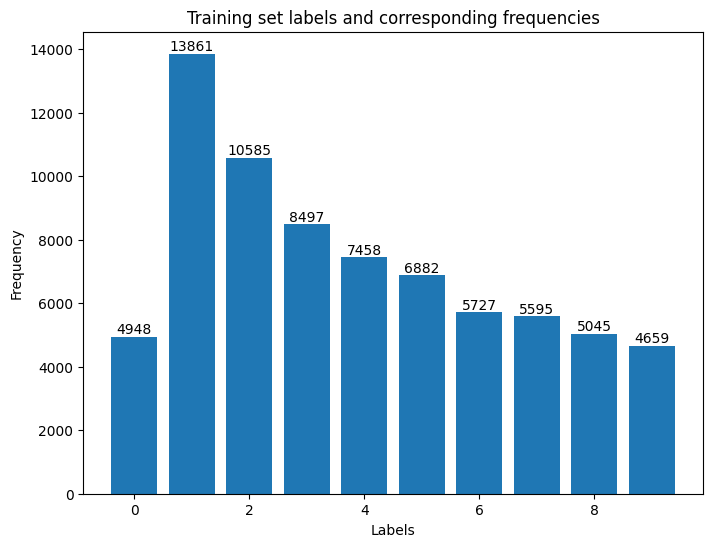

In [ ]:
# TODO: Create a barplot showing the distribution of the dataset
# TRAIN Data

plt.figure(figsize=(8, 6))
plt.bar(train_dataset_dict.keys(), train_dataset_dict.values())
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Training set labels and corresponding frequencies')
for label, freq in train_dataset_dict.items():
    plt.text(label, freq, str(freq), ha='center', va='bottom')
plt.show()

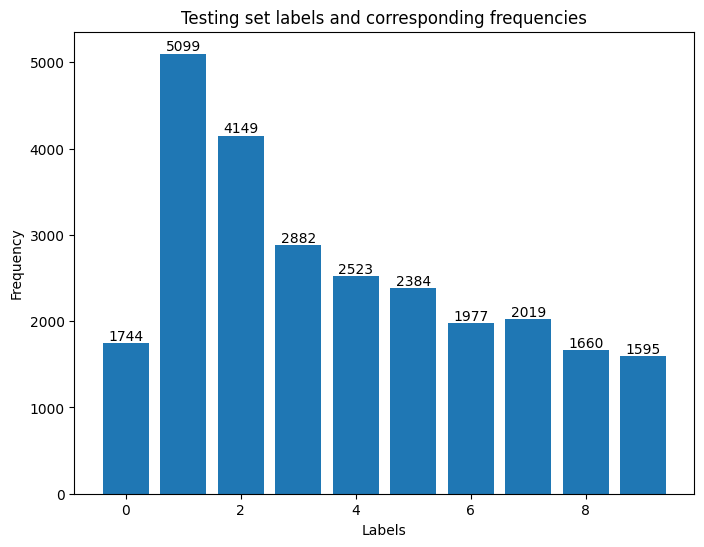

In [ ]:
# TODO: Create a barplot showing the distribution of the dataset
# TEST Data

plt.figure(figsize=(8, 6))
plt.bar(test_dataset_dict.keys(), test_dataset_dict.values())
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Testing set labels and corresponding frequencies')
for label, freq in test_dataset_dict.items():
    plt.text(label, freq, str(freq), ha='center', va='bottom')
plt.show()

### 1.2.3 Have equal spread of labels (5 points)

As you have seen in the previous parts, some classes have much lower representation in the dataset than others; this might cause issues as our dataset is currently skewed, meaning that the classes do not all have an equally likely chance of being selected randomly. We will change that in this section.

Recall that for our models we want **30,000** training images in our training data and **5,000** testing images in our testing data. In each dataset we want all our classes to have the same number of images.

These are the TODOs for this question:
* Downsample training by getting 30,000 images of the training data, with an equal representation for each class. Specify this dataframe as `train_subset`
* Downsample testing by getting 5,000 images of the training data, with an equal representation for each class. Specify this dataframe as `test_subset`

**Hints**:
* Check out [`torch.utils.data.Subset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Subset) for downsampling the dataset.
* When thinking about your function for getting the indices of a certain class (digit), think about how you were able to obtain that information in part 1.2.2



In [ ]:
torch.manual_seed(42)

# TODO: get 30000 indices for training data, with
# an equal number of images for each class
train_indices = []


# Optional: you can use train_count_dict to keep track of the
# counts (value) for each class (key). You are not required to use
# this if you think of an alternate method
train_count_dict = dict()

# Optional: one strategy might be iterating through each image
# and stopping the loop when you have the right amount of images
# for each class, storing the indices in train_indices.  You are
# not required to implement this idea.
target_images_per_class = 30000 // 10

for i in range(len(train_dataset)):
    img, label = train_dataset[i]
    if train_count_dict.get(label, 0) < target_images_per_class:
        train_indices.append(i)
        train_count_dict[label] = train_count_dict.get(label, 0) + 1

    if sum(train_count_dict.values()) >= target_images_per_class * 10:
        break

train_subset = torch.utils.data.Subset(train_dataset, train_indices)
# End TODO

In [ ]:
torch.manual_seed(42)

# TODO: get 5000 indices for testing data, with
# an equal number of images for each class
test_indices = []


# Optional: you can use test_count_dict to keep track of the
# counts (value) for each class (key). You are not required to use
# this if you think of an alternate method
test_count_dict = dict()

# Optional: one strategy might be iterating through each image
# and stopping the loop when you have the right amount of images
# for each class, storing the indices in test_indices.  You are
# not required to implement this idea.
target_images_per_class_test = 5000 // 10

for i in range(len(test_dataset)):
    img, label = test_dataset[i]
    if test_count_dict.get(label, 0) < target_images_per_class_test:
        test_indices.append(i)
        test_count_dict[label] = test_count_dict.get(label, 0) + 1

    if sum(test_count_dict.values()) >= target_images_per_class_test * 10:
        break

test_subset = torch.utils.data.Subset(test_dataset, test_indices)
# End TODO

In [ ]:
# TODO: create subsets of the training and testing data
train_subset = train_subset
test_subset = test_subset
# End TODO

Create `train_subset_dict` and `test_subset_dict` using a similar process from 1.2.1

In [ ]:
test_loader_bar_plot = DataLoader(test_subset, batch_size=len(test_subset), shuffle=True, num_workers=0)
train_loader_bar_plot = DataLoader(train_subset, batch_size=len(train_subset), shuffle=True, num_workers=0)

train_labels = [item[1] for item in train_loader_bar_plot.dataset]
test_labels = [item[1] for item in test_loader_bar_plot.dataset]

train_subset_dict = dict(Counter(train_labels))
test_subset_dict = dict(Counter(test_labels))

# TODO: verify the number of images are equal for every class
print(train_subset_dict)
print(test_subset_dict)

{1: 3000, 9: 3000, 2: 3000, 3: 3000, 5: 3000, 8: 3000, 7: 3000, 4: 3000, 6: 3000, 0: 3000}
{5: 500, 2: 500, 1: 500, 0: 500, 6: 500, 9: 500, 8: 500, 3: 500, 4: 500, 7: 500}


In [ ]:
# Optional: Create barplots to verify your downsampled dataframes here


In [ ]:
#Grader Cell (3 points)
grader.grade(test_case_id = 'subset', answer = (train_subset_dict, test_subset_dict))

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


Now that we have `train_subset` and `test_subset`, let's create dataloaders using these two datasets.

You can load the dataset into dataloaders using the `DataLoaders` object. Please refer to the documentation [here](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader).

---
**TODO**:
* Initialize the `DataLoader` object for `train_subset` as `train_loader`
* Initialize the `DataLoader` object for `test_subset` as `test_loader`
---

**NOTE**: set the `batch_size` equal to the previously-defined variable `batch`, set `shuffle` to `True`, and `num_workers` as 0.


In [ ]:
batch = 64
train_loader = DataLoader(train_subset, batch_size=batch, shuffle=True, num_workers=0)
test_loader = DataLoader(test_subset, batch_size=batch, shuffle=True, num_workers=0)
# TODO END

In [ ]:
#Grader Cell (2 points)
# DO NOT EDIT ANYTHING
trainLoaderCheck = [getattr(train_loader, "batch_size"),
                    str(type(train_loader)),
                    len(getattr(train_loader, "dataset")),
                    str(getattr(train_loader, "sampler")),
                    getattr(train_loader, "num_workers")]
testLoaderCheck = [getattr(test_loader, "batch_size"),
                    str(type(test_loader)),
                    len(getattr(test_loader, "dataset")),
                    str(getattr(test_loader, "sampler")),
                    getattr(test_loader, "num_workers")]
grader.grade(test_case_id = 'check_dataloader', answer = (trainLoaderCheck, testLoaderCheck))

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


# **Part 2:** Classification Models (Total: 77 points)

We now have the data needed to train a multi-class object classifier. We will start simple with a logistic regression classifier as a baseline for our performance, before we move onto more complex neural networks.

In this case, we are looking at the remaining part in the pipeline which were grayed out before as follows:


Diagram Reference: [Link](https://www.kaggle.com/code/uvxy1234/cifar-10-implementation-with-pytorch)

## 2.1 Multimonial Logical Logistic Regression - Baseline (Total: 13 points)

Let's first try solving this problem with a Multimonial Logistic Regression classifier.

We want to use a Multimonial Logistic Regression, since we're looking to predict between 10 different classes/digits.

We will define a logistic regression model in Pytorch and train it on our training set and evaluate the performance on the test set.

Logistic regression can be modelled as a function that can take in any number of inputs and constrain the output to be between 0 and 1. This means we can think of Logistic Regression as a one-layer neural network without hidden layers with some activation function. Think about how working with multiple classes may require you to think past a traditional Logistic Regression Model to optimize on performance!



Diagram Reference: [Link](https://stats.stackexchange.com/questions/366707/a-logistic-regression-with-neural-network-mindset-vs-a-shallow-neural-network)

### 2.1.1 Logistic Regression Model Architecture (5 points)

We will define our first model in Pytorch. Read up about how to define and use layers in a Pytorch neural network [here](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html).

Our first model is a logistic regression model with the number of outputs equal to the number of classes in the model. Please implement the constructor for the `LogReg` class (the `__init__` function below) with the definition of the logistic regression model.

When implementing this section, please think about what activation function would be most appropriate for logistic regression.

Note that each data sample is in the shape (3, 32, 32). The goal of our architecture is to flatten each image completely.

In addition, when constructing your architecture, be mindful of what your input and output dimensions should be for `in_features` and `out_features` based off the image dimensions!

In [ ]:
class LogReg(nn.Module):
    def __init__(self):
        super(LogReg, self).__init__()
        self.input_size = 3 * 32 * 32
        self.num_classes = 10
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(self.input_size, self.num_classes)
        # END TODO

    def forward(self, x):
        # TODO: implement the operations on input data
        # Hint: think of the neural network architecture for logistic regression
        x = self.flatten(x)
        outputs = self.linear(x)
        return outputs

Let's print the model summary

In [ ]:
LogReg()

LogReg(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=3072, out_features=10, bias=True)
)

In [ ]:
#Grader Cell (5 points)
grader.grade(test_case_id = 'logistic_regression_model', answer = str(LogReg()))

Correct! You earned 5/5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


**Notes:** Getting full credit for the above test case doesn't necessarily ensure that your model will perform well on the test dataset as it only evaluates the structure of your neural network.

If you don't achieve complete credit for accuracy and loss on the test dataset, you may need to modify your architecture.

### 2.1.2 Training Logistic Regression Model (4 points)
---
**TODOs:**
1.   Instantiate the Logistic regression to the variable `logreg`. Make sure to send this to the GPU device -- please consult the [Module 20 slides](https://docs.google.com/presentation/d/1pw9cFO30U_kI47JUZIW9COLAkM8BE8wr/edit?usp=sharing&ouid=115607071793138372214&rtpof=true&sd=true) for a primer on how to do this.

2.   Set the loss criterion as `CrossEntropyLoss` (you can look up the documentation [here](https://pytorch.org/docs/stable/nn.html#loss-functions)). Note that softmax is already built into CrossEntropyLoss so if you use CrossEntropyLoss as the loss criterion, you don't need to add an additional softmax layer.

3.   Fill in the missing parts in the training loop (see `#TODO` comments below)
4.   Save the Training Accuracy for every epoch into the variable `acc_LIST_log`.
5.   Save the Average Loss for every epoch into the variable `loss_LIST_log`.
---
The optimizer is set as Adam -- **please do not modify the optimizer**.

Hint: Remember to update the weights correctly by backpropagation, please zero out the gradients by calling `optimizer.zero_grad()` every time you call `backward()`.

**Note: If the loss went up during the training, there is something wrong with the model, so you should check if the model is implemented correctly**

In [ ]:
%%time
logreg = LogReg()
logreg.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(logreg.parameters(), lr=1e-4) #lr - learning step
epoch = 10
loss_LIST_log = []
acc_LIST_log = []
for epoch in range(epoch):
  running_loss = 0.0
  correct = 0
  total = 0
  for inputs, labels in train_loader:
      labels = labels.type(torch.LongTensor) # Cast to Float
      inputs, labels = inputs.to(device), labels.to(device)

      # TODO
      # Step 1: Reset the optimizer tensor gradient every mini-batch
      optimizer.zero_grad()

      # Step 2: Feed the network the train data
      outputs = logreg(inputs)

      # Step 3: Get the prediction using argmax
      temp, predicted = torch.max(outputs.data, 1)

      # Step 4: Find average loss for one mini-batch of inputs
      loss = criterion(outputs, labels)
      running_loss += loss.item()

      # Step 5: Do a back propagation
      loss.backward()

      # Step 6: Update the weight using the gradients from back propagation by learning step
      optimizer.step()

      # Step 7: Get loss and add to accumulated loss for each epoch


      # Step 8: Get number of correct prediction and add to correct and total
      # Hint: we need to detach the numbers from GPU to CPU, which stores accuracy and loss
      total += labels.size(0)
      correct += (predicted == labels).sum().item()


  # Step 9: Calculate training accuracy for each epoch and add to acc_LIST_log
  accuracy = 100 * correct / total
  acc_LIST_log.append(accuracy)

  # Step 10: Get average loss for each epoch and add to loss_LIST_log
  avg_loss = running_loss / len(train_loader)
  loss_LIST_log.append(avg_loss)

  # END TODO

  # print statistics
  print("The loss for Epoch {} is: {}, Accuracy = {}".format(epoch, running_loss/len(train_loader), accuracy))

The loss for Epoch 0 is: 2.2931936519232385, Accuracy = 15.566666666666666
The loss for Epoch 1 is: 2.251162907716308, Accuracy = 19.886666666666667
The loss for Epoch 2 is: 2.2358506096959876, Accuracy = 21.186666666666667
The loss for Epoch 3 is: 2.227320978128071, Accuracy = 22.253333333333334
The loss for Epoch 4 is: 2.2215692214111784, Accuracy = 22.92
The loss for Epoch 5 is: 2.215076800856763, Accuracy = 23.46
The loss for Epoch 6 is: 2.213365380189566, Accuracy = 23.6
The loss for Epoch 7 is: 2.208907246335483, Accuracy = 24.013333333333332
The loss for Epoch 8 is: 2.205942848343839, Accuracy = 24.243333333333332
The loss for Epoch 9 is: 2.203304455224385, Accuracy = 24.523333333333333
CPU times: user 1min 28s, sys: 399 ms, total: 1min 28s
Wall time: 1min 29s


In [ ]:
# (if applicable)
# In order to pass the AutoGrader, every element in "acc_LIST_log" should be a float.
# If the elements are of type "Tensor", convert each element into type FLOAT by using .item() or .tolist()
# To check if each element is a Tensor, print out "acc_LIST_log" and see if there is a Tensor() wrapped around each element.


In [ ]:
# Grader Cell (4 points)
grader.grade(test_case_id = 'log_train_loss', answer = (acc_LIST_log, loss_LIST_log))

Correct! You earned 4/4 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 2.1.3 Plotting Training Accuracy vs Epochs for Logistic Regression (2 points - Manually Graded)

---
**TODO:**

Plot the training accuracy vs epochs.

Chart Specifications:
1. The accuracy should be in the y-axis and epochs in x-axis.
2. Add chart title.
3. Epoch label should start with 1 (for audience interpretability).
4. To avoid "File Too Large" for submission, please set figure size to (5,3).
---

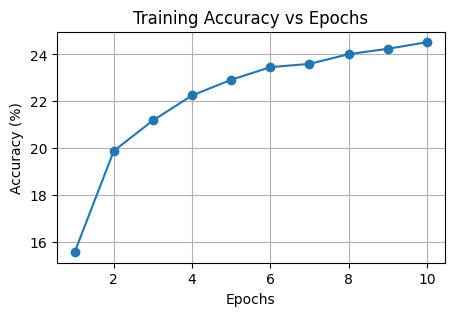

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# TODO
plt.figure(figsize=(5, 3))
plt.plot(range(1, 10 + 1), acc_LIST_log, marker='o')
plt.title('Training Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.show()
# END TODO


### 2.1.4 Logistic Regression Model Accuracy (2 points)

Calculate the Test Accuracy for the Logistic Regression Model we trained above.

This should be similar to how we calculated training accuracy above.

In [ ]:
total = 0
correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        labels = labels.type(torch.LongTensor) # Cast to Float
        images, labels = images.to(device), labels.to(device)

        # TODO
        # Get the output
        outputs = logreg(images)

        # Get the prediction using argmax
        temp, predicted = torch.max(outputs.data, 1)

        # Get number of correct prediction and add to correct and total
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate test accuracy for logistic regression (should multiple by 100)
test_acc_log = (correct / total) * 100

# TODO END
print('Test Accuracy: ' + str(test_acc_log))

Test Accuracy: 18.2


In [ ]:
#Grader Cell (2 points)
grader.grade(test_case_id = 'logistic_regression_test_acc', answer = test_acc_log)

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## 2.2 Feedforward Neural Networks (Total: 25 points)



Diagram reference: [Link](https://en.wikipedia.org/wiki/Feedforward_neural_network)

**NOTE:** For 2.2 and 2.3, getting full points on the autograder for certain test cases may not be indicative of correctness; there may be slight inaccuracies in how your structured/architectured your model, or errors in your forwards. Losing points in the autograder can most likely be attributed to this.


Since logistic regression isn't that great at the classification problem above, we need more representation power in our model. We will now define a feedforward neural network.

For this section, we're going to first create three different types of data inputs to analyze the performance in each.



1.   First, we're going to analyze how well the *FNN* model will perform for a data input that only inludes data for the **red pixel values**. Since the shape of each one of our samples is (3, 32, 32), we're going to condense this down to (1, 32, 32) using a model architecture that can handle this new shape.
2.   Second, we're going to analyze the performance of an *FNN* model on a data input that only includes data for the **grayscale values** of the image. As a reminder, the grayscale value of a pixel are calculated from the the average of the red, green, and blue pixel values. The shape of each sample should be (1, 32, 32)
3. Finally, we'll use all of our inputs without modification to see how our *FNN* model performs with all data. We'll need to create a different architecture to handle the different sample size, but the original data loaders can be used.

For each of these steps, think about the **relative information loss** between each data input and how you think that might affect the model.


### 2.2.1 FNN Preprocessing Helper Functions (2 points)

To simulate the first two, fill in the following functions that can convert a raw data sample of shape (batch_size, channels, 32, 32) to 1. contrained to only red values (index 0) and 2. gray scale values (averaged).

For both functions, the datatype should be a tensor.


### 2.2.1 Feedforward Neural Network Model Architecture (10 points)

In [ ]:
def raw_sample_to_red(sample):
  # TODO: Fill in the logic to convert an input tensor of shape (batch_size, 3, 32, 32) to just contain the red values
  red_sample = sample[:, 0:1, :, :]
  return red_sample

def raw_sample_to_grayscale(sample):
  # TODO: Fill in the logic to convert an input tensor of shape (batch_size, 3, 32, 32) to just contain the grey scale values
  grayscale_sample = torch.mean(sample, dim=1, keepdim=True)
  return grayscale_sample


In [ ]:
# DO NOT EDIT
dummy_data = torch.rand(1, 3, 32, 32)
dummy_input = dummy_data[0, :, 0, 0].tolist()
red_output = raw_sample_to_red(dummy_data)[0, 0, 0, 0].item()
gray_output = round(raw_sample_to_grayscale(dummy_data)[0, 0, 0, 0].item(), 4)

# Grader Cell (2 points)
grader.grade(test_case_id = 'feedforward_preprocess_helpers', answer = (dummy_input, red_output, gray_output))

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 2.2.2 Feedforward Neural Network Model Architecture (4 points)

Now, complete the *FNN* class below to define a feedforward neural network architecture with **only 1 hidden layers with ```out_features``` of 256**. Note that the last layer must have the same number of classes as the output size! Also, note that this architecture will be using the shapes **(1, 32, 32)** to accomadate for the first two types of data.

When implementing this model, please think about what activation function would be most appropriate for each layer in this classifier.

Note: Receiving full credit for this section won't guarantee that future sections will work as intended! We're primarily testing that you have all the required components in your architecture!


In [ ]:
class FNN(nn.Module):
    def __init__(self):
        super().__init__()
        # TODO: initialize the neural network layers

        self.flatten = nn.Flatten()
        self.hidden_layer = nn.Linear(1 * 32 * 32, 256)
        self.relu = nn.ReLU()
        self.output_layer = nn.Linear(256, 10)

        # END TODO

    def forward(self, x):
        # TODO: implement the operations on input data
        # Hint: think of the neural network architecture for FNN
        x = self.flatten(x)
        x = self.hidden_layer(x)
        x = self.relu(x)
        outputs = self.output_layer(x)

        # END TODO
        return outputs

Let's print the model summary

In [ ]:
FNN()

FNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (hidden_layer): Linear(in_features=1024, out_features=256, bias=True)
  (relu): ReLU()
  (output_layer): Linear(in_features=256, out_features=10, bias=True)
)

In [ ]:
#Grader Cell (4 points)
grader.grade(test_case_id = 'feedforward_nn_model', answer = str(FNN()))

Correct! You earned 4/4 points. You are a star!

Your submission has been successfully recorded in the gradebook.


**Notes:** Getting full credit for the above test case doesn't necessarily ensure that your model will perform well on the test dataset as it only evaluates the structure of your neural network.

If you don't achieve complete credit for accuracy and loss on the test dataset, you may need to modify your architecture such as increasing the number of hidden layers or the number of neurons in each layer.

### 2.2.3 Training FNN Model (11 points)
---
TODOs
1.   Instantiate an FNN model to the variable `fnn_red` (make sure to send this to the device env)
2.   Set the loss criterion to be `CrossEntropyLoss` (you can look up the documentation [here](https://pytorch.org/docs/stable/nn.html#loss-functions))
3.   Fill in the missing parts in the training loop below.
4.   Note, make sure you are using your raw_sample_to_red() helper function to convert each raw input into our desired form
5.   Save the Training Accuracy for every epoch into `acc_LIST_FNN_red`
6.   Save the Average Loss for every epoch into `loss_LIST_FNN_red`
---
The optimizer is set as Adam -- **please do not modify the optimizer**.

Hint: Remember to update the weights correctly by backpropagation, please zero out the gradients by calling `optimizer.zero_grad()` every time you call `backward()`.

**Note 1**: If the loss went up during the training, there is something wrong with the model, so you should check if the model is implemented correctly.

**Note 2**: Typical training time could around 5 mins.



Note: `acc_LIST_FNN_red` should be of type floats, instead of tensors.

In [ ]:
%%time
# Sending the data to device (CPU or GPU)
# TODO

# Step 1: instantiate the FNN model to variable fnn_red
fnn_red = FNN()
fnn_red.to(device)

# Step 2: set the loss criterion as CrossEntropyLoss
criterion_fnn_red = nn.CrossEntropyLoss()

# END TODO
optimizer = optim.Adam(fnn_red.parameters(), lr=1e-4) #lr - learning step
epoch = 10

acc_LIST_FNN_red = []
loss_LIST_FNN_red = []

# Train the FNN
for epoch in range(epoch):
  running_loss = 0.0
  correct = 0
  total = 0
  for inputs, labels in train_loader:
      labels = labels.type(torch.LongTensor) # Cast to Long
      inputs, labels = inputs.to(device), labels.to(device)

      # TODO
      # Step 1: Reset the optimizer tensor gradient every mini-batch
      optimizer.zero_grad()

      # Step 2: Feed the network the train data (use helper)
      inputs_red = raw_sample_to_red(inputs)
      outputs = fnn_red(inputs_red)

      # Step 3: Get the prediction using argmax
      temp, predicted = torch.max(outputs.data, 1)

      # Step 4: Find average loss for one mini-batch of inputs
      loss = criterion_fnn_red(outputs, labels)

      # Step 5: Do a back propagation
      loss.backward()

      # Step 6: Update the weight using the gradients from back propagation by learning step
      optimizer.step()

      # Step 7: Get loss and add to accumulated loss for each epoch
      running_loss += loss.item()

      # Step 8: Get number of correct prediction and add to correct and total
      # Hint: we need to detach the numbers from GPU to CPU, which stores accuracy and loss
      total += labels.size(0)
      correct += (predicted == labels).sum().item()


  # Step 9: Calculate training accuracy for each epoch and add to acc_LIST_FNN_red
  accuracy = 100 * correct / total
  acc_LIST_FNN_red.append(accuracy)


  # Step 10: Get average loss for each epoch and add to loss_LIST_FNN_red
  avg_loss = running_loss / len(train_loader)
  loss_LIST_FNN_red.append(avg_loss)

  # END TODO

  # print statistics
  print("The loss for Epoch {} is: {}, Accuracy = {}".format(epoch, running_loss/len(train_loader), accuracy))



The loss for Epoch 0 is: 2.0148664580733535, Accuracy = 37.25333333333333
The loss for Epoch 1 is: 1.4784199721269262, Accuracy = 60.61333333333334
The loss for Epoch 2 is: 1.2385914673937408, Accuracy = 65.53666666666666
The loss for Epoch 3 is: 1.1168435304912168, Accuracy = 68.45666666666666
The loss for Epoch 4 is: 1.0346055678975608, Accuracy = 70.41666666666667
The loss for Epoch 5 is: 0.9729098666197201, Accuracy = 71.73
The loss for Epoch 6 is: 0.9208435280236609, Accuracy = 73.47
The loss for Epoch 7 is: 0.8773731936269732, Accuracy = 74.80333333333333
The loss for Epoch 8 is: 0.8396230412444581, Accuracy = 75.78
The loss for Epoch 9 is: 0.8071069169019077, Accuracy = 76.87666666666667
CPU times: user 1min 34s, sys: 536 ms, total: 1min 34s
Wall time: 1min 35s


Nice, you should see here that the accuracy of our model is significantly improved by adding an additional hidden layer to our architecture when we use an FNN model. Can we do better? Let's create a second training loop, but this time, we'll use our grayscale helper instead.



1.   This time, initialize your model to the variable `fnn_gray`
2.   Use the same criterion, and training loop parameters as last time.
3.   Use our newly defined `raw_sample_to_grayscale` helper to convert to grayscale inputs.
4.   Save the accuracy and loss to `acc_LIST_FNN_gray` and `loss_LIST_FNN_gray`

In [ ]:
%%time
# Sending the data to device (CPU or GPU)
# TODO

# Step 1: instantiate the FNN model to variable fnn_gray
fnn_gray = FNN()
fnn_gray.to(device)
# Step 2: set the loss criterion as CrossEntropyLoss
criterion_fnn_gray = nn.CrossEntropyLoss()
# END TODO
optimizer = optim.Adam(fnn_gray.parameters(), lr=1e-4) #lr - learning step
epoch = 10

acc_LIST_FNN_gray = []
loss_LIST_FNN_gray = []

# Train the FNN
for epoch in range(epoch):
  running_loss = 0.0
  correct = 0
  total = 0
  for inputs, labels in train_loader:
      labels = labels.type(torch.LongTensor) # Cast to Long
      inputs, labels = inputs.to(device), labels.to(device)

      # TODO
      # Step 1: Reset the optimizer tensor gradient every mini-batch
      optimizer.zero_grad()

      # Step 2: Feed the network the train data (use helper)
      inputs_gray = raw_sample_to_grayscale(inputs)
      outputs = fnn_gray(inputs_gray)

      # Step 3: Get the prediction using argmax
      temp, predicted = torch.max(outputs.data, 1)

      # Step 4: Find average loss for one mini-batch of inputs
      loss = criterion_fnn_gray(outputs, labels)

      # Step 5: Do a back propagation
      loss.backward()

      # Step 6: Update the weight using the gradients from back propagation by learning step
      optimizer.step()

      # Step 7: Get loss and add to accumulated loss for each epoch
      running_loss += loss.item()

      # Step 8: Get number of correct prediction and add to correct and total
      # Hint: we need to detach the numbers from GPU to CPU, which stores accuracy and loss
      total += labels.size(0)
      correct += (predicted == labels).sum().item()


  # Step 9: Calculate training accuracy for each epoch and add to acc_LIST_FNN_gray
  accuracy = 100 * correct / total
  acc_LIST_FNN_gray.append(accuracy)
  # Step 10: Get average loss for each epoch and add to loss_LIST_FNN_gray

  avg_loss = running_loss / len(train_loader)
  loss_LIST_FNN_gray.append(avg_loss)

  # END TODO

  # print statistics
  print("The loss for Epoch {} is: {}, Accuracy = {}".format(epoch, running_loss/len(train_loader), accuracy))


The loss for Epoch 0 is: 2.0435628751193535, Accuracy = 36.07666666666667
The loss for Epoch 1 is: 1.4971196580289015, Accuracy = 60.59
The loss for Epoch 2 is: 1.2405381632257881, Accuracy = 65.88333333333334
The loss for Epoch 3 is: 1.1124906178984815, Accuracy = 68.58
The loss for Epoch 4 is: 1.0297281227386328, Accuracy = 70.55333333333333
The loss for Epoch 5 is: 0.9670480789660391, Accuracy = 72.32
The loss for Epoch 6 is: 0.9141110265051632, Accuracy = 73.88333333333334
The loss for Epoch 7 is: 0.8709827939838742, Accuracy = 75.03333333333333
The loss for Epoch 8 is: 0.8317206052701864, Accuracy = 76.23666666666666
The loss for Epoch 9 is: 0.799244549927681, Accuracy = 77.12666666666667
CPU times: user 1min 39s, sys: 644 ms, total: 1min 40s
Wall time: 1min 48s


### 2.2.4 Feed Forward Network on Raw Inputs Architecture (4 points)


Finally, let's see how the model fares with the normal raw inputs. Note the raw inputs have a different sample shape (3, 32, 32), so we'll first need to define a new model architecture to handle this.

Fill in the rest of the code for the model architecture below. The only thing you should be changing is the shape of the data that gets passed through the model

In [ ]:
class FNN_RAW(nn.Module):
    def __init__(self):
        super().__init__()
        # TODO: initialize the neural network layers
        self.flatten = nn.Flatten()
        self.hidden_layer = nn.Linear(3 * 32 * 32, 256)
        self.relu = nn.ReLU()
        self.output_layer = nn.Linear(256, 10)
        # END TODO

    def forward(self, x):
        # TODO: implement the operations on input data
        x = self.flatten(x)
        x = self.hidden_layer(x)
        x = self.relu(x)
        outputs = self.output_layer(x)

        # END TODO
        return outputs

Let's print the model summary

In [ ]:
FNN_RAW()

FNN_RAW(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (hidden_layer): Linear(in_features=3072, out_features=256, bias=True)
  (relu): ReLU()
  (output_layer): Linear(in_features=256, out_features=10, bias=True)
)

In [ ]:
#Grader Cell (4 points)
grader.grade(test_case_id = 'feedforward_nn_model_raw', answer = str(FNN_RAW()))

Correct! You earned 4/4 points. You are a star!

Your submission has been successfully recorded in the gradebook.


And now, let's define one last training loop to take in the raw data. The training loop should be largely identical to the previous two training loops created. We do not need a helper function to preprocess any training samples.


1.   Define a new FNN model using the `FNN_RAW` class defined above and save the model as `fnn`
2.   Use the same criterion and parameters as before.
3.   Save the accuracy and loss to `acc_LIST_FNN` and `loss_LIST_FNN` respectively



In [ ]:
%%time
# Sending the data to device (CPU or GPU)
# TODO

# Step 1: instantiate the FNN model to variable fnn
fnn = FNN_RAW()
fnn.to(device)
# Step 2: set the loss criterion as CrossEntropyLoss
criterion_fnn = nn.CrossEntropyLoss()
# END TODO
optimizer = optim.Adam(fnn.parameters(), lr=1e-4)
epoch = 10

acc_LIST_FNN = []
loss_LIST_FNN = []

# Train the FNN
for epoch in range(epoch):
  running_loss = 0.0
  correct = 0
  total = 0
  for inputs, labels in train_loader:
      labels = labels.type(torch.LongTensor) # Cast to Long
      inputs, labels = inputs.to(device), labels.to(device)

      # Step 1: Reset the optimizer tensor gradient every mini-batch
      optimizer.zero_grad()

      # Step 2: Feed the network the train data
      outputs = fnn(inputs)

      # Step 3: Get the prediction using argmax
      temp, predicted = torch.max(outputs.data, 1)

      # Step 4: Find average loss for one mini-batch of inputs
      loss = criterion_fnn(outputs, labels)

      # Step 5: Do a backpropagation
      loss.backward()

      # Step 6: Update the weight using the gradients from backpropagation by learning step
      optimizer.step()

      # Step 7: Get loss and add to accumulated loss for each epoch
      running_loss += loss.item()

      # Step 8: Get number of correct predictions and add to correct and total
      total += labels.size(0)
      correct += (predicted == labels).sum().item()


  # Step 9: Calculate training accuracy for each epoch and add to acc_LIST_FNN
  accuracy = 100 * correct / total
  acc_LIST_FNN.append(accuracy)

  # Step 10: Get average loss for each epoch and add to loss_LIST_FNN
  avg_loss = running_loss / len(train_loader)
  loss_LIST_FNN.append(avg_loss)

  # END TODO

  # print statistics
  print("The loss for Epoch {} is: {}, Accuracy = {}".format(epoch, running_loss/len(train_loader), accuracy))


The loss for Epoch 0 is: 1.783489883835636, Accuracy = 45.026666666666664
The loss for Epoch 1 is: 1.2133679321325663, Accuracy = 65.67
The loss for Epoch 2 is: 1.0435666130549872, Accuracy = 69.80333333333333
The loss for Epoch 3 is: 0.9445783080322656, Accuracy = 72.51333333333334
The loss for Epoch 4 is: 0.8680112358730739, Accuracy = 74.83
The loss for Epoch 5 is: 0.8051721302431021, Accuracy = 76.73
The loss for Epoch 6 is: 0.7566644670739611, Accuracy = 78.16
The loss for Epoch 7 is: 0.7138359151415224, Accuracy = 79.40666666666667
The loss for Epoch 8 is: 0.6781764591553572, Accuracy = 80.39333333333333
The loss for Epoch 9 is: 0.6442429976168472, Accuracy = 81.58666666666667
CPU times: user 1min 32s, sys: 526 ms, total: 1min 33s
Wall time: 1min 34s


Now, let's compile together all of our training results from our three models

In [ ]:
# (if applicable)
# In order to pass the AutoGrader, every element in “acc_LIST_FNN”, "acc_LIST_FNN_red", and "acc_LIST_FNN_gray" should be a float.
# If the elements are of type “Tensor”, convert each element into type FLOAT by using .item() or .tolist()
# To check if each element is a Tensor, print out “acc_LIST_FNN” and see if there is a Tensor() wrapped around each element.


In [ ]:
#Grader Cell (11 points)
grader.grade(test_case_id = 'fnn_train_loss', answer = (acc_LIST_FNN_red, loss_LIST_FNN_red, acc_LIST_FNN_gray, loss_LIST_FNN_gray, acc_LIST_FNN, loss_LIST_FNN))

Correct! You earned 11/11 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 2.2.5 Plotting Training Accuracy vs Epochs FNN (2 points - Manually Graded)

---
**TODO:**

Plot the training accuracy vs epochs for all three models. Make sure there is some way to distinguish the three models (by color) and a key to distinguish each line.

Chart Specifications:
1. The accuracy should be in the y-axis and epochs in x-axis.
2. Add chart title.
3. Epoch label should start with 1 (for audience interpretability).
4. To avoid "File Too Large" for submission, please set figure size to (5,3).
---

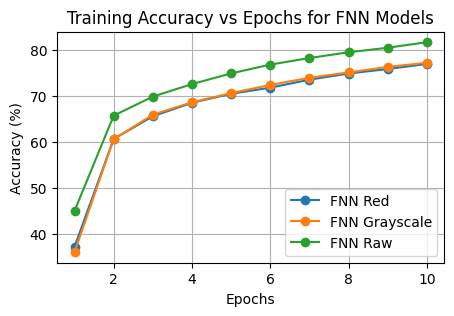

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# TODO
plt.figure(figsize=(5, 3))

# Plot for FNN model with red inputs
plt.plot(range(1, 10 + 1), acc_LIST_FNN_red, marker='o', label='FNN Red')

# Plot for FNN model with grayscale inputs
plt.plot(range(1, 10 + 1), acc_LIST_FNN_gray, marker='o', label='FNN Grayscale')

# Plot for FNN_RAW model with raw inputs
plt.plot(range(1, 10 + 1), acc_LIST_FNN, marker='o', label='FNN Raw')

plt.title('Training Accuracy vs Epochs for FNN Models')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()
# END TODO

### 2.2.6 FNN Model Accuracy (2 points)

Calculate the Test Accuracy for the three FNN Model we trained above (the technique for doing this is the same as computing the test accuracy for the logistic regression classifier above).

Remember, your models should be named `fnn`, `fnn_red`, and `fnn_gray`, and make sure to use the same respective helper function to process the test data set as well.

Save your correct to their respective variables as well.

In [ ]:
total = 0
correct_fnn = 0
correct_fnn_red = 0
correct_fnn_gray = 0
with torch.no_grad():
    for images, labels in test_loader:
        labels = labels.type(torch.LongTensor) # Cast to Float
        images, labels = images.to(device), labels.to(device)

        # TODO
        # Get the output
        outputs_fnn = fnn(images)
        inputs_red = raw_sample_to_red(images)
        outputs_fnn_red = fnn_red(inputs_red)
        inputs_gray = raw_sample_to_grayscale(images)
        outputs_fnn_gray = fnn_gray(inputs_gray)

        # Get the prediction using argmax
        _temp, predicted_fnn = torch.max(outputs_fnn.data, 1)
        _r, predicted_fnn_red = torch.max(outputs_fnn_red.data, 1)
        _g, predicted_fnn_gray = torch.max(outputs_fnn_gray.data, 1)

        # Get number of correct prediction and add to correct and total
        total += labels.size(0)
        correct_fnn += (predicted_fnn == labels).sum().item()
        correct_fnn_red += (predicted_fnn_red == labels).sum().item()
        correct_fnn_gray += (predicted_fnn_gray == labels).sum().item()

# Calculate test accuracy for FNN (should multiple by 100)
test_acc_FNN = (correct_fnn / total) * 100
test_acc_FNN_red = (correct_fnn_red / total) * 100
test_acc_FNN_gray = (correct_fnn_gray / total) * 100

# TODO END
print('Test Accuracy (Red Values Only): ' + str(test_acc_FNN_red))
print('Test Accuracy (Grayscale Values Only): ' + str(test_acc_FNN_gray))
print('Test Accuracy (All Values): ' + str(test_acc_FNN))


Test Accuracy (Red Values Only): 71.02000000000001
Test Accuracy (Grayscale Values Only): 71.46000000000001
Test Accuracy (All Values): 75.22


In [ ]:
#Grader Cell (2 points)
grader.grade(test_case_id = 'feedforward_nn_acc', answer = (test_acc_FNN_red, loss_LIST_FNN_red, test_acc_FNN_gray, loss_LIST_FNN_gray, test_acc_FNN, loss_LIST_FNN))

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


##2.3 "Convoluted" Convolutional Neural Networks (Total: 29 points)
So, what are CNNs?

Convolutional Neural Networks are very similar to Feedforward Neural Networks from the previous section: they are made up of neurons that have learnable weights and biases. Each neuron receives some inputs, performs a dot product and optionally follows it with a non-linearity. The whole network still expresses a single differentiable score function: from the raw image pixels on one end to class scores at the other.

So what changes? ConvNet architectures make the explicit assumption that the inputs are images, which allows us to encode certain properties into the architecture. These then make the forward function more efficient to implement and vastly reduce the amount of parameters in the network.

If you wanna know more about how CNNs function and see some cool visualizations, we would highly recommend this [page](https://cs231n.github.io/convolutional-networks/)


Diagram Reference: [Link](https://www.analyticsvidhya.com/blog/2020/10/what-is-the-convolutional-neural-network-architecture/)

We will define the architecture for the CNN we will be using. The components of a CNNs are as follows:

*   Convolutional Layers
*   Pooling Layers
*   Linear Layers
*   Activation Functions

Define a CNN model with Pytorch that contains one or more blocks, where **each block** consists of a **convolutional layer** followed by an **activation function** and a **max pool**. (For this assignment, we discourage adding three or more layers.)

Then, **flatten** the output from the convolutional layers, and pass it through one or more fully connected or 'dense' layers and activation functions after all but the last layer. Note that the output shape from the last layer must be the same as the number of classes.

### 2.3.0 Calculating Output Dimensions of Convolution and Pooling Layers (1 Point)

Before we start building the architecture, it's important to understand the dimensions of the feature maps produced in each of the convolution and pooling layers. We want to keep track of this information as once we get to the fully-connected layers, we need to specify the number of input parameters.

Let's first build a function that will help us calculate the dimensions based on the input parameters.


Since we are working with squared image, we will build just one function that can be used to calculate both the H (height) and W (width) of the feature map.

Below is the function used to calculate the output dimension of the feature map:

Diagram Reference: [Link](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)

---
**TODO:**

Build the **feature_map_dim** function, which takes in the following four parameters and return the dimension of the output feature map.

- **input_dim**: height/width of the input image

- **kernel_size**: size of the convolving kernel (aka. filter)

- **padding**: padding added to all four sides of the input in order to preserve the edges/borders

- **stride**: Stride of the convolution, or how many shifts per kernel
  
ROUND DOWN if the result if a fraction.

---

Notice there is another parameter, "dilation", which is the spacing between kernel elements. We have not covered this in class; simply set it to 1.


In [ ]:
import math

def feature_map_dim(input_dim, padding, kernel_size, stride):
  '''
  The function takes in the following four parameters and return the dimension of the output feature map.

  input_dim: height/width of the input image
  kernel_size: size of the convolving kernel (aka. filter)
  padding: padding added to all four sides of the input in order to preserve the edges/borders
  stride: Stride of the convolution, or how many shifts per kernel

  ROUND DOWN if the result if a fraction.

  Notice there is another parameter, "dilation", which is the spacing between kernel elements. We have not covered this in class; simply set it to 1
  '''
  ## TODO:
  output_dim = math.floor((input_dim + 2 * padding - 1 * (kernel_size - 1) - 1) / stride) + 1

  return output_dim

  ## END TODO

In [ ]:
#Grader Cell (1 point)
grader.grade(test_case_id = 'test_func_feature_map_dim', answer = (feature_map_dim))

Correct! You earned 1/1 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 2.3.1 Create your own custom Convolutional Neural Network Architecture (8 points)

For this section, you will be creating your own custom Convolutional Neural Network Architecture for this dataset. Typically, this would mean defining your neural network architecture within your `__init__` function of your Neural Network class. Within this initializer, you would define the individual layers of the network, which would typically consist of some number of `convolutional layers`, some number of `fully connected layers`, and other types of layers such as `pooling layers` and `dropout layers`.

One thing that you will need to pay attention to is how exactly the data is being input to your Convolutional Neural Network. That is, what are the input dimensions, and how does the dimensions of the data change as it is propagated through the network. Note that your choice of layering and the order of layers will determine the corresponding input and output dimensions of each layer.

---
**TODOs:**

`def __init__(self)`::
1.  Initialize some number of `convolutional blocks` (consists of a convolution layer, an activation function, and a Pooling layer)

2. `Flatten` the output of the convolution to a tensor

3. Initialize some number of `fully-connected layers`

`def forward(self, x)`:
4. Build the `forward` function/path with the layers initialized in `__init__` function.

---

- **Note:** While parameters of convolution layers tend to vary, it is possible to use the same pooling layer and activation function in each block. If you intend to use the same parameters for these two elements, then only 1 pooling layer and 1 activation function needs to be initialized.
- **Hint 1**: Use the `feature_map_dim` function, and the input_dim and output_dim comments to help you keep track of the input/output dimensions of each layer. Speficially, for each layer you include in your model, make sure to understand what the input dimensions would be, how that changes as you apply each layer to the next layer's input.
- **Hint 2**: The parameters you've calculated is particularly useful for the input dimensions for the linear layer in the first fully-connected layer.
- **Hint 3**: The final fully-connected layer's output dimension should be the same as the number of classes in our dataset


In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        # TODO: Initialize some number of convolutional blocks
        self.num_classes = 10
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)

        # Flatten the output of the convolution to a tensor
        self.flatten = nn.Flatten()

        # TODO: Initialize some number of fully-connected layers
        self.fc1 = nn.Linear(in_features=8 * 16 * 16, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=self.num_classes)

        # TODO

    def forward(self, x):
      x = self.conv1(x)
      x = self.relu(x)
      x = self.pool(x)

      x = self.conv2(x)
      x = self.relu(x)
      x = self.pool(x)

      x = self.flatten(x)

      x = self.fc1(x)
      x = self.relu(x)

      x = self.fc2(x)

      return x

In [ ]:
CNN()

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
# DO NOT EDIT
grader.grade(test_case_id = 'cnn_model', answer = str(CNN()))

Correct! You earned 8/8 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 2.3.2 Training CNN Model (8 Points)

---
**TODOs**
1.   Instantiate the CNN to the variable `cnn` (make sure to send this to the device env)
2.   Set the criterion as a CrossEntropyLoss (you can look up the documentation [here](https://pytorch.org/docs/stable/nn.html#loss-functions))
3.   Fill in the missing parts in the training loop.
4.   Calculate training accuracy for each epoch (should multiply by 100 to get percentage), store in variable called `accuracy`.
5.   Save the Training Accuracy for every epoch into `acc_LIST_CNN`
6.   Save the Average Loss for every epoch into `loss_LIST_CNN`

**Please do not modify the following set ups: **
Optimizer: The optimizer is set as "Adam".
Epoch: The epoch is set to "10".

---

**Hint:** Remember to update the weights correctly by backpropagation, please zero out the gradients by calling `optimizer.zero_grad()` every time you call `backward()`.  Please review the `Recitation 10` notebook for detailed instructions on how to perform these operations.

**Note 1**: If the loss went up during the training, there is something wrong with the model, so you should check if the model is implemented correctly.

**Note 2**: Typical training time takes between 5 - 10 mins.

**Note 3**: `acc_LIST_CNN` and `loss_LIST_CNN` should contain data of type float not tensor.

In [ ]:
%%time
# Sending the data to device (CPU or GPU)
# TODO (1 of 2)
# Step 1: instantiate the CNN model to variable cnn
cnn = CNN().to(device)
criterion = nn.CrossEntropyLoss()
# Step 2: set the loss criterion as CrossEntropyLoss

# END TODO
optimizer = optim.Adam(cnn.parameters(), lr=1e-4) #lr - learning step
epoch = 10

acc_LIST_CNN = []
loss_LIST_CNN = []

# Train the CNN
for epoch in range(epoch):
  running_loss = 0.0
  correct = 0
  total = 0
  for inputs, labels in train_loader:
      labels = labels.type(torch.LongTensor) # Cast to Float
      inputs, labels = inputs.to(device), labels.to(device)
      ## TODO (2 of 2)
      # Step 1: Reset the optimizer tensor gradient every mini-batch
      optimizer.zero_grad()

      # Step 2: Feed the network the train data
      outputs = cnn(inputs)

      # Step 3: Get the prediction using argmax
      temp, predicted = torch.max(outputs.data, 1)

      # Step 4: Find average loss for one mini-batch of inputs
      loss = criterion(outputs, labels)

      # Step 5: Do a back propagation
      loss.backward()

      # Step 6: Update the weight using the gradients from back propagation by learning step
      optimizer.step()

      # Step 7: Get loss and add to accumulated loss for each epoch
      running_loss += loss.item()

      # Step 8: Get number of correct prediction and increment the number of correct and total predictions after this batch
      correct += (predicted == labels).sum().item()
      total += labels.size(0)

  # Step 9: Calculate training accuracy for each epoch (should multiply by 100 to get percentage), store in variable called 'accuracy', and add to acc_LIST_CNN
  accuracy = (correct / total) * 100
  acc_LIST_CNN.append(accuracy)

  # Step 10: Get average loss for each epoch and add to loss_LIST_CNN
  loss_LIST_CNN.append(running_loss / len(train_loader))

  # END TODO

  # print statistics
  print("The loss for Epoch {} is: {}, Accuracy = {}".format(epoch, running_loss/len(train_loader), accuracy))


The loss for Epoch 0 is: 2.1360507550270063, Accuracy = 26.94666666666667
The loss for Epoch 1 is: 1.2332220372360652, Accuracy = 64.85666666666667
The loss for Epoch 2 is: 0.8788698027128858, Accuracy = 74.86666666666667
The loss for Epoch 3 is: 0.7520559973426973, Accuracy = 78.68333333333334
The loss for Epoch 4 is: 0.6809105008904105, Accuracy = 80.89333333333333
The loss for Epoch 5 is: 0.6335375358555109, Accuracy = 82.20333333333333
The loss for Epoch 6 is: 0.5945502139612048, Accuracy = 83.46666666666667
The loss for Epoch 7 is: 0.5651079552895479, Accuracy = 84.17666666666666
The loss for Epoch 8 is: 0.5394338957790626, Accuracy = 84.88
The loss for Epoch 9 is: 0.5157687512796316, Accuracy = 85.50666666666666
CPU times: user 1min 35s, sys: 554 ms, total: 1min 36s
Wall time: 1min 37s


In [ ]:
# (if applicable)
# In order to pass the AutoGrader, every element in "acc_LIST_CNN" should be a float.
# If the elements are of type "Tensor", convert each element into type FLOAT by using .item() or .tolist()
# To check if each element is a Tensor, print out "acc_LIST_CNN" and see if there is a Tensor() wrapped around each element.


In [ ]:
#Grader Cell (10 points)
grader.grade(test_case_id = 'cnn_train_loss', answer = (acc_LIST_CNN, loss_LIST_CNN))

Correct! You earned 10/10 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 2.3.3 Plotting Training Accuracy vs Epochs CNN (2 points - Manually Graded)

---
**TODO:**

Plot the training accuracy vs epochs.

Chart Specifications:
1. The accuracy should be in the y-axis and epochs in x-axis.
2. Add chart title.
3. Epoch label should start with 1 (for audience interpretability).
4. To avoid "File Too Large" for submission, please set figure size to (5,3).
---

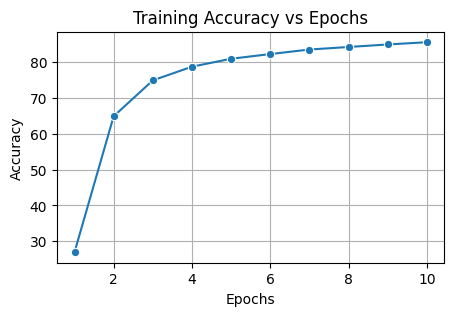

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# TODO
epochs = range(1, len(acc_LIST_CNN) + 1)

plt.figure(figsize=(5, 3))
sns.lineplot(x=epochs, y=acc_LIST_CNN, marker='o')
plt.title('Training Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

# END TODO

### 2.3.4 CNN Model Test Accuracy (2 points)

---
**TODO:**
Calculate the Test Accuracy for the CNN Model we trained above. Save it to the variable named `test_acc_CNN`. The technique for doing this is the same as computing the test accuracy for the logistic regression and FNN classifiers above.

---

In [ ]:
# TODO
total = 0
correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        labels = labels.type(torch.LongTensor) # Cast to Float
        images, labels = images.to(device), labels.to(device)
        # TODO
        # Get the output
        outputs = cnn(images)

        # Get the prediction using argmax
        temp, predicted = torch.max(outputs.data, 1)

        # Get number of correct prediction and add to correct and total
        correct += (predicted == labels).sum().item()
        total += labels.size(0)



# Calculate test accuracy for CNN (should multiple by 100)
test_acc_CNN = (correct / total) * 100
# TODO END

print(f'Test Accuracy: ' + str(test_acc_CNN))

Test Accuracy: 81.5


In [ ]:
#Grader Cell (2 points)
grader.grade(test_case_id = 'cnn_test_acc', answer = (test_acc_CNN))

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 2.3.5 CNN Hyperparameter Tuning (8 points)

In this section, we will now explore how we can find an "optimal" Convolutional Neural Network architecture by tuning some hyperparameters. Hyperparameters are those parameters that we usually manually set that have some impact on the learning process for our model. For this section, we will particularly focus on the `learning rate`, `beta1`, `beta2` and `number of fully connected layers`.

The `learning rate`, `beta1` and `beta2` parameters all have to do with the optimizer we are using `optim.Adam`. The `beta1` and `beta2` parameters that control the contribution of the past gradients and the past square gradients to the current update, while the learning rate controls the step size taken during optimization.

Now, create a new model that will be used in the hyperparameter tuning. This can be identical to the model that you had previously, or you can make slight tweaks to it if you desire. You must, however, include an attribute that stores the number of fully connected layers that will be controlled by the hyperparameter tuning. Make sure to understand how to implement this while maintaining the dimensionality of your data

In [ ]:
# TODO: Create a new model CNNTuned whose hyperaparameters we will tune
import torch.nn.functional as F
class CNNTuned(nn.Module):
    def __init__(self, ff_layers = 3):
        super().__init__()
        # TODO
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)

        # Define pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        # Define fully connected layers based on the ff_layers hyperparameter
        fc_layers = []
        in_features = 256 * 4 * 4  # Assuming input image size is 32x32
        for _ in range(ff_layers):
            fc_layers.append(nn.Linear(in_features, 512))
            fc_layers.append(nn.ReLU())
            in_features = 512  # Update in_features for the next layer
        self.fc_layers = nn.Sequential(*fc_layers)

        # Define the output layer
        self.out_layer = nn.Linear(512, 10)

    def forward(self, x):
        # TODO
        # Forward pass through convolutional layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # Flatten the output for fully connected layers
        x = x.view(-1, 256 * 4 * 4)

        # Forward pass through fully connected layers
        x = self.fc_layers(x)

        # Forward pass through the output layer
        x = self.out_layer(x)

        return x

The way we will tune these hyperparameters is by conducting a gridsearch on these various hyperparameters. To start, we first need to create the actual `parameter_grid`. This will define which parameters we want to test different values for, as well as include an array of the different values that we would like to test for each parameter. Make sure to play around with these values, but have a constraint on the number of values in your grid to prevent excessive runtimes (it will test every possible combination of these parameters, so the larger the grid, the more time it will take). We recommend you limit the size of each hyperparameter to three values.

To create our parameter grid to tune on, we first make the following import.

In [ ]:
from sklearn.model_selection import ParameterGrid

**HINT**: The entry for betas should be a list of size 2 tuples containing floats

In [ ]:
# TODO: Define your parameter grid. pgrid should
# just be the wrapped version of param_grid using ParameterGrid
# num_epochs will be the number of epochs you use to grid search and train

param_grid = {
    'learning_rate': [1e-3, 5e-4, 1e-4],
    'betas': [(0.9, 0.999), (0.95, 0.995), (0.99, 0.99)],
    'num_fc_layers': [2, 3, 4]
}

# Wrap the parameter grid using ParameterGrid
pgrid = list(ParameterGrid(param_grid))

num_epochs = 10

In [ ]:
# DO NOT EDIT
grader.grade(test_case_id='cnn_hyper_param_grid', answer = param_grid)

Correct! You earned 1/1 points. You are a star!

Your submission has been successfully recorded in the gradebook.


Now, go through every combination of parameters using your parameter grid and determine which of the combinations yields the best model.

Note: this will take some time to run especially as you increase the number of epochs. You must run it for at least 5 epochs.

**HINT 1**: You need to create some form of a training loop to do this. (Think about what it means for a model to be "the best" in this case.)

**HINT 2**: You also might want to keep track of what combos are better than others

In [ ]:
# TODO: Conduct your grid search.
best_accuracy = 0.0
best_hyperparameters = None

for hyperparameters in pgrid:
    # Instantiate the model with the current set of hyperparameters
    cnn_tuned = CNNTuned(ff_layers=hyperparameters['num_fc_layers']).to(device)

    # Set the loss criterion as CrossEntropyLoss
    criterion = nn.CrossEntropyLoss()

    # Set the optimizer with the current hyperparameters
    optimizer = optim.Adam(cnn_tuned.parameters(), lr=hyperparameters['learning_rate'],
                           betas=hyperparameters['betas'])

    acc_LIST_CNN_TUNE = []
    loss_LIST_CNN_TUNE = []

    # Train the CNN with the current hyperparameters
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            labels = labels.type(torch.LongTensor)
            inputs, labels = inputs.to(device), labels.to(device)

            # Reset the optimizer tensor gradient every mini-batch
            optimizer.zero_grad()

            # Feed the network the train data
            outputs = cnn_tuned(inputs)

            # Get the prediction using argmax
            temp, predicted = torch.max(outputs.data, 1)

            # Find average loss for one mini-batch of inputs
            loss = criterion(outputs, labels)

            # Do a back propagation
            loss.backward()

            # Update the weight using the gradients from back propagation by learning step
            optimizer.step()

            # Get loss and add to accumulated loss for each epoch
            running_loss += loss.item()

            # Get number of correct prediction and increment the number of correct and total predictions after this batch
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        # Calculate training accuracy for each epoch (should multiply by 100 to get percentage)
        accuracy = correct / total * 100
        acc_LIST_CNN_TUNE.append(accuracy)

        # Get average loss for each epoch and add to loss_LIST_CNN_TUNE
        avg_loss = running_loss / len(train_loader)
        loss_LIST_CNN_TUNE.append(avg_loss)

        # Save the best hyperparameters based on accuracy
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_hyperparameters = hyperparameters

        # Print statistics
        print("Epoch {}: Loss = {}, Accuracy = {}".format(epoch, avg_loss, accuracy))

# Print the best hyperparameters
print("Best Hyperparameters:", best_hyperparameters)

Epoch 0: Loss = 1.2674688857628593, Accuracy = 55.489999999999995
Epoch 1: Loss = 0.49810623236175283, Accuracy = 84.53333333333333
Epoch 2: Loss = 0.37677388280820745, Accuracy = 88.38666666666667
Epoch 3: Loss = 0.3067972647514679, Accuracy = 90.45
Epoch 4: Loss = 0.2520363079284681, Accuracy = 92.17666666666666
Epoch 5: Loss = 0.19856775123109696, Accuracy = 93.79666666666667
Epoch 6: Loss = 0.16633879532342527, Accuracy = 94.87666666666667
Epoch 7: Loss = 0.14200972945594204, Accuracy = 95.48
Epoch 8: Loss = 0.1083882256978944, Accuracy = 96.61666666666666
Epoch 9: Loss = 0.09872427536671095, Accuracy = 96.92333333333333
Epoch 0: Loss = 1.8297965558353009, Accuracy = 30.459999999999997
Epoch 1: Loss = 0.6489538873817875, Accuracy = 79.27333333333333
Epoch 2: Loss = 0.4406599239118572, Accuracy = 86.37
Epoch 3: Loss = 0.3529486635219314, Accuracy = 88.93666666666667
Epoch 4: Loss = 0.29197625687190976, Accuracy = 91.04666666666667
Epoch 5: Loss = 0.24860228374123827, Accuracy = 92.3

Now that you have run the grid search, find the best hyperparameters and use them to train your model. This training loop should be similar to the one you created in 2.3.2, except now using the the best hyperparameters you found in the grid search.

In [ ]:
# TODO: Create a training loop similar to 2.3.2 that
# uses the best hyperparameters that you found

%%time

acc_LIST_CNN_TUNE = []
loss_LIST_CNN_TUNE = []

# Define the best hyperparameters
best_hyperparameters = {'betas': (0.95, 0.995), 'learning_rate': 0.0005, 'num_fc_layers': 2}

# Instantiate the CNNTuned model with the best hyperparameters
cnn_tuned = CNNTuned(ff_layers=best_hyperparameters['num_fc_layers']).to(device)

# Set the loss criterion as CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

# Set the optimizer with the best hyperparameters
optimizer = optim.Adam(cnn_tuned.parameters(), lr=best_hyperparameters['learning_rate'], betas=best_hyperparameters['betas'])

# Number of epochs
num_epochs = 10

# Train the CNN with the best hyperparameters
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        labels = labels.type(torch.LongTensor)  # Cast to Long
        inputs, labels = inputs.to(device), labels.to(device)

        # Reset the optimizer tensor gradient every mini-batch
        optimizer.zero_grad()

        # Feed the network the train data
        outputs = cnn_tuned(inputs)

        # Get the prediction using argmax
        temp, predicted = torch.max(outputs.data, 1)

        # Find average loss for one mini-batch of inputs
        loss = criterion(outputs, labels)

        # Do a backpropagation
        loss.backward()

        # Update the weight using the gradients from backpropagation by learning step
        optimizer.step()

        # Get loss and add to accumulated loss for each epoch
        running_loss += loss.item()

        # Get number of correct prediction and increment the number of correct and total predictions after this batch
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    # Calculate training accuracy for each epoch (should multiply by 100 to get percentage)
    accuracy = correct / total * 100
    acc_LIST_CNN_TUNE.append(accuracy)

    # Get average loss for each epoch and add to loss_LIST_CNN_TUNE
    loss_LIST_CNN_TUNE.append(running_loss / len(train_loader))

    # Print statistics
    print("The loss for Epoch {} is: {}, Accuracy = {}".format(epoch, running_loss / len(train_loader), accuracy))


# Train the CNN

The loss for Epoch 0 is: 1.4174834496812272, Accuracy = 50.12
The loss for Epoch 1 is: 0.5645173543742471, Accuracy = 82.84
The loss for Epoch 2 is: 0.4263303951223268, Accuracy = 86.96666666666667
The loss for Epoch 3 is: 0.343636978902161, Accuracy = 89.43333333333334
The loss for Epoch 4 is: 0.2855625029867773, Accuracy = 91.33666666666667
The loss for Epoch 5 is: 0.24073719292053028, Accuracy = 92.81333333333333
The loss for Epoch 6 is: 0.18874084230647412, Accuracy = 94.19
The loss for Epoch 7 is: 0.1547577982780331, Accuracy = 95.27666666666667
The loss for Epoch 8 is: 0.12039055096517716, Accuracy = 96.28
The loss for Epoch 9 is: 0.10148972068835836, Accuracy = 96.75
CPU times: user 2min 1s, sys: 638 ms, total: 2min 2s
Wall time: 2min 3s


In [ ]:
grader.grade(test_case_id = 'cnn_tuning_train_loss', answer = (acc_LIST_CNN_TUNE, loss_LIST_CNN_TUNE))

Correct! You earned 5/5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


Now, run your new model on the test data and gauge its performance.

In [ ]:
total = 0
correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        labels = labels.type(torch.LongTensor) # Cast to Float
        images, labels = images.to(device), labels.to(device)
        # TODO
        # Get the output
        outputs = cnn_tuned(images)

        # Get the prediction using argmax
        _, predicted = torch.max(outputs.data, 1)

        # Get number of correct prediction and add to correct and total
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

# Calculate test accuracy for CNN (should multiple by 100)
test_acc_CNN = 100 * correct / total
# TODO END

print(f'Test Accuracy: ' + str(test_acc_CNN))

Test Accuracy: 87.14


In [ ]:
grader.grade(test_case_id = 'cnn_tuning_test_acc', answer = test_acc_CNN)

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## 2.4. Reflection



Let's compare the model performance:

From the test accuracies, we can see that FNN works better than Logistic Regression, and CNN works even better than FNN.

In [ ]:
# Simply run this cell, please do not modify
print(f'Test Accuracy for Logistic Regression: ' + str(test_acc_log))
print(f'Test Accuracy for FNN: ' + str(test_acc_FNN))
print(f'Test Accuracy for CNN: ' + str(test_acc_CNN))

Test Accuracy for Logistic Regression: 18.2
Test Accuracy for FNN: 75.22
Test Accuracy for CNN: 87.14


---
**TODO:**

Now that you've build an image classification model on a relatively simple dataset, could you think of a real-world practical/complex application/use-case where digit recognition is useful?

---

In [ ]:
# Type your response in the following cell as a comment
# In the context of speed limit detection, image classification models
# trained on digit recognition can be employed to recognize speed limit signs
# in real-world traffic scenes, contributing to automated systems that enhance
# road safety and assist in enforcing speed regulations. This application aids
# in efficiently identifying and processing speed limit information, supporting
# intelligent transportation systems for improved traffic management and compliance.



## 2.5 Confusion Matrix (Total: 8 points)

We want to give you some insight into how you can further analyze the performance of the classification model you have trained.

Upto now we have only used accuracy as a measure of performance. Although accuracy is simple and widely used measure, there are drawbacks to using accuracy.

Assume that we are trying to train a model to detect a rare disease from CT images of patients. For simplicity, assume that this rare disease has an incidence rate of 1%.

In this situation, if we train a degenerative model which always predicts that the patient does not have the disease, the accuracy is very high, namely 99%! Obviously in this case, accuracy is not a good measure of performance of the model.

This example serves to motivate confusion matrices and related metrics.

A confusion matrix is defined to be $C \times C$ 2D matrix, where $C$ is number of distinct labels in the dataset. In this matrix, the rows represent the actual labels and the columns represent the predicted labels.

The $(i, j)$-th entry of the confusion matrix contains the no. of data points where the actual label is $i$ but the model predicted $j$.


The provided image is an example of a confusion matrix for binary classification (C = 2), but you can easily imagine this scaling up to C > 2.

From this confusion matrix we can get all sorts of useful metrics such as False Positive Rate (FPR), False Negative Rate (FNR), Recall, Precision, etc... If you are interested in learning more about confusion matrix and related metrics [this wikipedia page](https://en.wikipedia.org/wiki/Confusion_matrix#cite_note-11) is a good place to look at.







### 2.5.1 Create a confusion matrix (4 points)

---

**TODO:**
1. For the test dataset using the CNN model you have trained above, create a confusion matrix. Do this by creating a function called `cm_generator` which will return the labels and predictions from testing.
2. Save the confusion matrix as a pandas dataframe called `confusion_matrix_df`.

---
**Hint:** Look at what you've done in 2.3.4, and see if what you have done can be re-used.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix

# TODO

def cm_generator(test_loader):

  # The goal is to obtain two lists of prediction and actual labels.
  # Then, using these two lists, create a confusion matrix dataframe
    cnn_tuned.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = cnn_tuned(inputs)
            temp, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    return all_labels, all_preds
# END TODO

all_labels, all_preds = cm_generator(test_loader)

# Create confusion matrix dataframe
confusion_matrix_df = pd.DataFrame(confusion_matrix(all_labels, all_preds), index=range(10), columns=range(10))


In [ ]:
#Grader Cell (4 points)
grader.grade('check_confusion_matrix', (str(type(confusion_matrix_df)),
                                        confusion_matrix_df.shape,
                                        confusion_matrix_df.to_numpy().sum(),
                                        np.trace(confusion_matrix_df.to_numpy())
                                        ))

Correct! You earned 4/4 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 2.5.2 Visualizing Confusion Matrix (4 points - Manual Grading)

---
**TODOs:**

Implement the code to visualize the confusion matrix you have created above. This section will be manually graded

Suggested library is using Seaborn heatmap.

Chart Specifications:
1. Each cell is labled/annotated with associated values. Take a look at the parameter "annot".
2. Make sure all annotated values are in integers, and not shown in scientific notations. Use the parameter `fmt = "g"`.
3. Add chart title, and axis name label ("Actual" and "Predicted". Check out which axis is associated with either label.
4. Set map color to Green/Blue.
5. To avoid "File Too Large" for submission, please set figure size to (8,4).
---
Resource: [Seaborn Heatmap documentation](https://seaborn.pydata.org/generated/seaborn.heatmap.html )

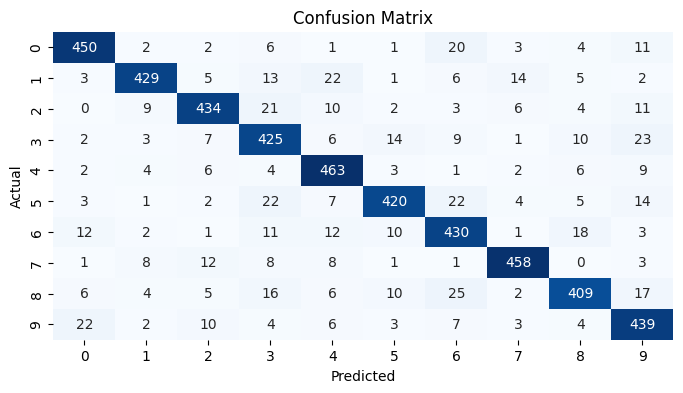

In [ ]:
# TODO
plt.figure(figsize=(8, 4))
sns.heatmap(confusion_matrix_df, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
# END TODO

# Part 3: Time Series Data (Total: 8 points)

Thus far we have looked models that utilize various features to output a certain target (perhaps a score in regression problems, a label in classification problems as seen above). In other words, we have been looking at the relationship of an output as a function of various features. But what if we want to track an output as a function of **time**?

In this section, we will be exploring time series data and forecasting; many real-world problems have a time component, making the extrapolation of time series data extremely important. One can think about the pandemic, when we used time series models like ARIMA to predict **daily COVID cases** ([link](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7445441/)). Or consider the stock market; when you are choosing a stock, you definitely look at the **prior history of the share price**; over the past year, the past month, or even the past week. Time series models are instrumental in assisting you with predicting the price of a stock in the near future.

Another simple instance for the need for time series models is page view statistics; meaning, in a given timeframe, how many times was a webpage accessed. To get you ready for a much deserved Thanksgiving break, we will be looking at page view data for the Wikipedia article for "Thanksgiving" seen [here](https://en.wikipedia.org/wiki/Thanksgiving). (As an aside, you can easily get the page view statistics of any Wikipedia article using [this](https://pageviews.wmcloud.org/?project=en.wikipedia.org&platform=all-access&agent=user&redirects=0&range=latest-20&pages=) link)

In this section we will be forecasting the number of page views for the "Thanksgiving" Wikipedia article in November, with the assistance of a time series model called **Prophet**.

### 3.1 Prepare Data (2 points)

Load in the thanksgiving dataframe. Keep in mind that it consists of page views on a given day **UP UNTIL THE LAST DAY OF NOVEMBER 2022**

In [ ]:
# Get the csv file (thanksgiving.csv)
! wget -nc https://storage.googleapis.com/penn-cis5450/thanksgiving.csv

--2023-11-24 19:24:15--  https://storage.googleapis.com/penn-cis5450/thanksgiving.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 2607:f8b0:4023:c0d::cf, 2607:f8b0:4023:c06::cf, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 43562 (43K) [text/csv]
Saving to: ‘thanksgiving.csv’

thanksgiving.csv    100%[===================>]  42.54K  --.-KB/s    in 0s      

2023-11-24 19:24:15 (192 MB/s) - ‘thanksgiving.csv’ saved [43562/43562]



In [ ]:
# TODO: Read in the thanksgiving dataset
# Make sure that the "Date" column is of type date
thanksgiving_df = pd.read_csv('thanksgiving.csv')
thanksgiving_df['Date'] = pd.to_datetime(thanksgiving_df['Date'])

Rename the `Date` column `ds` and the `Views` column `y`. This is crucial for running the Prophet model

In [ ]:
# TODO: Rename the "Date" column "ds" and the "Views" column "y"
# This is crucial for running the Prophet model
thanksgiving_df = thanksgiving_df.rename(columns={'Date': 'ds', 'Views': 'y'})

Split this dataframe into training and test data. The training data should consist of entries **BEFORE NOVEMBER 2022**, meaning the testing data consists from entries from November 1, 2022 onwards.


**MAKE SURE TO USE RESET_INDEX FUNCTION FOR BOTH DATAFRAMES TO AVOID AUTOGRADER ISSUES**

In [ ]:
# TODO: Create thanksgiving_train and thanksgiving_test as defined above
thanksgiving_train = thanksgiving_df.loc[thanksgiving_df['ds'] < '2022-11-01'].reset_index(drop=True)
thanksgiving_test = thanksgiving_df.loc[thanksgiving_df['ds'] >= '2022-11-01'].reset_index(drop=True)

In [ ]:
#Grader Cell (2 points)
grader.grade(test_case_id = 'prepare_data', answer = (thanksgiving_train, thanksgiving_test))

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 3.2 Prophet Model (6 points)

Prophet is a model developed by Facebook that is used for forecasting time series data, similar to ARIMA, a model you have explored or will explore soon in lecture. As you might imagine, forecasting future statistics, like the number of daily views on a certain webpage or advertisement, is very important to companies like Facebook.

In this section you will be exploring the Prophet model and comparing **two types of models**; one where you do not account for holidays (Thanksgiving is a U.S. holiday), and one where you do account for holidays.

Please refer to the Prophet documentation [here](https://facebook.github.io/prophet/docs/quick_start.html#python-api). This page has ALL the information you will need to complete this section

#### 3.2.1 Prophet Model (Base) (4 points)

In this section you will instantiate a Prophet model. **Do not do anything else besides fit the model on the train data**

In [ ]:
# TODO: Create and fit a Prophet model on your training data.
# DO NOT DO ANY OTHER PREPROCESSING STEPS! Just instantiate the model
# and train it on thanksgiving_train
m = Prophet()
m.fit(thanksgiving_train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbobgi8jt/qqgf71ul.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbobgi8jt/j5k6a1io.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48032', 'data', 'file=/tmp/tmpbobgi8jt/qqgf71ul.json', 'init=/tmp/tmpbobgi8jt/j5k6a1io.json', 'output', 'file=/tmp/tmpbobgi8jt/prophet_model0dv3qa8o/prophet_model-20231124192820.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:28:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:28:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


With this model, forecast the number of page views in November 2022. Refer to the documentation to see which function(s) you should use.

When done correctly, you should notice three important columns: yhat_lower (lower bound), yhat (predicted value) and yhat_upper (upper bound).

Save the predictions (**only yhat**) to a dataframe called **future_df**. This dataframe should be **30 entries long**, as there are 30 days in November (same size as the test dataframe).


**Final Schema for future_df**:
>ds | yhat |
>--- | --- |

In [ ]:
# TODO: forecast the daily page view numbers for November 2022,
# save them to a dataframe called future_df
future = m.make_future_dataframe(periods=30, freq='D', include_history=False)
forecast = m.predict(future)
future_df = forecast[['ds', 'yhat']]

Create a line plot in matplotlib that has both the **predicted (Prophet forecasting)** and **actual page views (from thanksgiving_test)** for November 2022. Make sure to have appropriate labels, clearly differentiate the predicted vs actual views and make a legend, make the x ticks legible, and title the graph "Page Views for Thanksgiving Article (November 2022)."

This graph is solely designed to help you visualize the data, so do not worry too much about exact dimension sizes of the plot or anything like that.

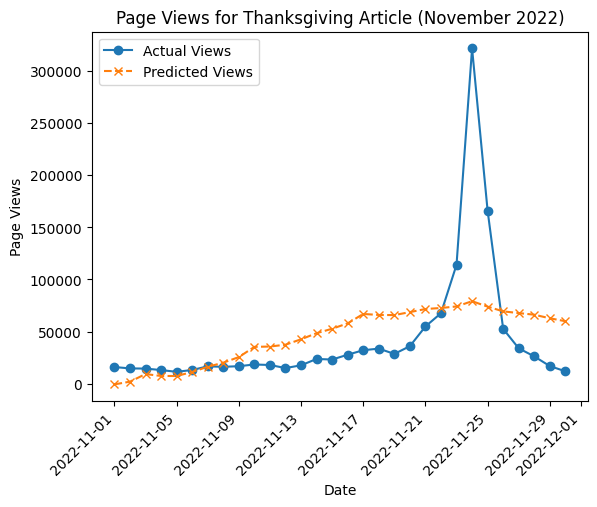

In [ ]:
# TODO: Make a lineplot comparing the predicted page view numbers with the actual
# page view numbers
plt.plot(thanksgiving_test['ds'], thanksgiving_test['y'], label='Actual Views', marker='o')
plt.plot(future_df['ds'], future_df['yhat'], label='Predicted Views', linestyle='--', marker='x')
plt.xlabel('Date')
plt.ylabel('Page Views')
plt.title('Page Views for Thanksgiving Article (November 2022)')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
#Grader Cell (4 points)
grader.grade(test_case_id = 'prophet_base', answer = (future_df, thanksgiving_test))

Correct! You earned 4/4 points. You are a star!

Your submission has been successfully recorded in the gradebook.


#### 3.2.2 Prophet Model (Holiday) (2 points)

As you saw in the previous section, the base model does a decent job at anticipating an increase in views as we get closer to Thanksgiving Day, but does a poor job of predicting a massive spike on the day itself. Let us see what happens when we rerun the Prophet model but allow the model to incorporate US holidays into its prediction.

In this section, you will again instantiate and fit a Prophet model, **but now add US holidays to the model** (again, please refer to the documentation to find out how you can do this).

In [ ]:
# TODO: Create and fit a Prophet model on your training data.
# MAKE SURE TO CONSIDER NATIONAL (US) HOLIDAYS
m = Prophet()
m.add_country_holidays(country_name='US')
m.fit(thanksgiving_train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbobgi8jt/bcaxqlmj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbobgi8jt/gzmul2nc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19538', 'data', 'file=/tmp/tmpbobgi8jt/bcaxqlmj.json', 'init=/tmp/tmpbobgi8jt/gzmul2nc.json', 'output', 'file=/tmp/tmpbobgi8jt/prophet_modelr1xo69g9/prophet_model-20231124193640.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:36:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:36:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Create **future_holiday_df** using the same process you had for creating future_df

In [ ]:
# TODO: create future_holiday_df
future_holiday_df = m.make_future_dataframe(periods=30, freq='D', include_history=False)
forecast = m.predict(future_holiday_df)
future_holiday_df = forecast[['ds', 'yhat']]

Again, create a line plot in matplotlib that has both the **predicted (Prophet forecasting)** and **actual page views (from thanksgiving_test)** for November 2022. Make sure to have appropriate labels, clearly differentiate the predicted vs actual views and make a legend, make the x ticks legible, and title the graph "Page Views for Thanksgiving Article (November 2022)."

This graph is solely designed to help you visualize the data, so do not worry too much about exact dimension sizes of the plot or anything like that.

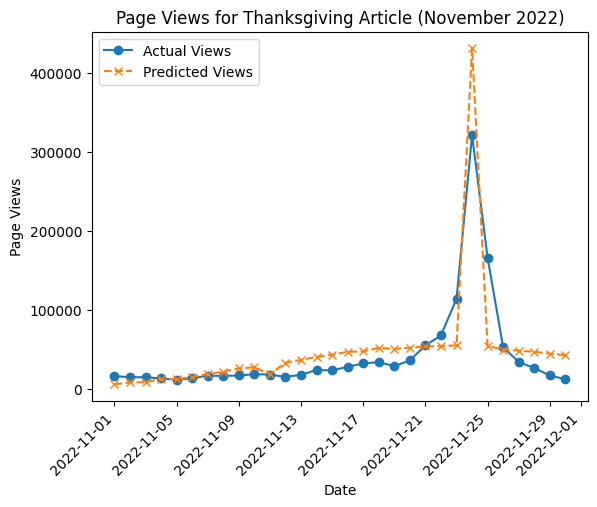

In [ ]:
plt.plot(thanksgiving_test['ds'], thanksgiving_test['y'], label='Actual Views', marker='o')
plt.plot(future_holiday_df['ds'], future_holiday_df['yhat'], label='Predicted Views', linestyle='--', marker='x')
plt.xlabel('Date')
plt.ylabel('Page Views')
plt.title('Page Views for Thanksgiving Article (November 2022)')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.show()

**Much better!**

In [ ]:
#Grader Cell (2 points)
grader.grade(test_case_id = 'prophet_improved', answer = (future_holiday_df, thanksgiving_test))

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


# Homework Submission

Good job! You have finished the homework :) The submission instructions are as follows:

* **Double check** that you have the correct PennID (all numbers) in the autograder.

* **Triple check** that you have all plots shown in this Colab notebook before submitting (otherwise, your submission will be subjected to a **penalty of -5 points**).

*  Go to the "File" tab at the top left of the Colab UI, click "Download .ipynb" and then "Download .py".  **Rename** these two files to `homework5.ipynb` and `homework5.py` respectively and upload them to Gradescope.
  - <ins>**WAIT UNTIL THE GRADESCOPE AUTOGRADER FINISHES RUNNING!**</ins> If we have to manually upload this for you after the deadline, **we will apply a penalty of -5 points** (this stacks with any other penatlies)

* You must submit your notebook to receive credit. Post any issues with submission on Ed and make sure to keep in mind the late day policy.

* After you submit your code, the teaching staff will manually grade your Colab notebook in order to validate the correctness of your code.